In [ ]:
import os 

from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
import numpy as np

import skfuzzy as fuzz
import skfuzzy.control as ctrl

from PIL import Image

from dataset_generation import *

# Dataset generation and quality checks.

To create dataset 3 parameters are generated:
* Distance - to obstacle, in meters
* Speed - in meters per second (for calculations convenience)
* Friction - implicitly defining state of the road (low for wet, high for dry)

We do not sanity-check the data to explore AI actions in edge cases.

In [2]:
SAVED_DF_PATH = 'data/dataset.csv'
NUM_SAMPLES = 1000

df = None
if os.path.exists(SAVED_DF_PATH):
    df = pd.read_csv(SAVED_DF_PATH)
else:
    df = create_dataset(NUM_SAMPLES, free_road_percentage=0.0)
    df.to_csv(SAVED_DF_PATH, header=True, index=False)

In [3]:
df.sample(10, random_state=42)

,distance_to_obstacle,vehicle_speed,friction
521,31.0,11.181,0.516681
737,163.0,6.465,0.701373
740,190.0,24.800,0.779813
660,115.0,21.183,0.776876
411,37.0,36.933,0.482463
678,68.0,3.189,0.544202
626,169.0,17.952,0.454237
513,156.0,9.560,0.659891
859,18.0,3.532,0.556544
136,142.0,32.077,0.760791


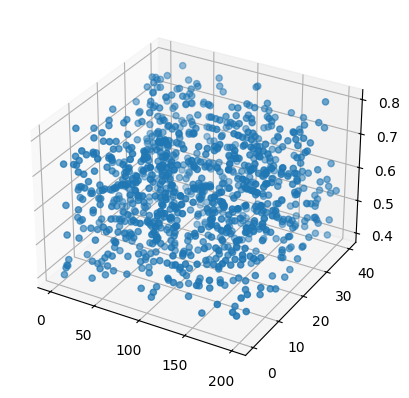

In [4]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(df['distance_to_obstacle'], df['vehicle_speed'], df['friction'], marker='o')
plt.show()

# Fuzzy sets, functions and rules creation
We are going to be using scikit-fuzzy with numpy functions which are suitable to define variables and membership functions. Scikit-fuzzy also allows for simple rule creation and inference, but it lacks to provide a good way to explore the computation step-by-step.

### Defining fuzzy sets for input variables

In [5]:
speed = ctrl.Antecedent(np.arange(MAX_SPEED), 'speed')
distance = ctrl.Antecedent(np.arange(MAX_DISTANCE), 'distance')
road_state = ctrl.Antecedent(np.arange(MIN_FRICTION, MAX_FRICTION + 0.1, 0.1), 'road_state')

### Defining membership functions

In [6]:
SPEED_THRESHOLDS = [
    (0, 5, 15),
    (10, 20, 30),
    (20, 40, 40),
]

DISTANCE_THRESHOLDS = [
    (0, 0, 50),
    (30, 70, 100),
    (70, 200, 200)
]

In [7]:
distance['small'] = fuzz.trimf(distance.universe, DISTANCE_THRESHOLDS[0])
distance['medium'] = fuzz.trimf(distance.universe, DISTANCE_THRESHOLDS[1])
distance['large'] = fuzz.trimf(distance.universe, DISTANCE_THRESHOLDS[2])

speed['low'] = fuzz.trimf(speed.universe, SPEED_THRESHOLDS[0])
speed['medium'] = fuzz.trimf(speed.universe, SPEED_THRESHOLDS[1])
speed['high'] = fuzz.trimf(speed.universe, SPEED_THRESHOLDS[2])

road_state['wet'] = fuzz.trapmf(road_state.universe, [0.4, 0.4, 0.5, 0.6])
road_state['dry'] = fuzz.trapmf(road_state.universe, [0.5, 0.7, 0.8, 0.8])

d:\conda\envs\comp_int\lib\site-packages\skfuzzy\control\fuzzyvariable.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


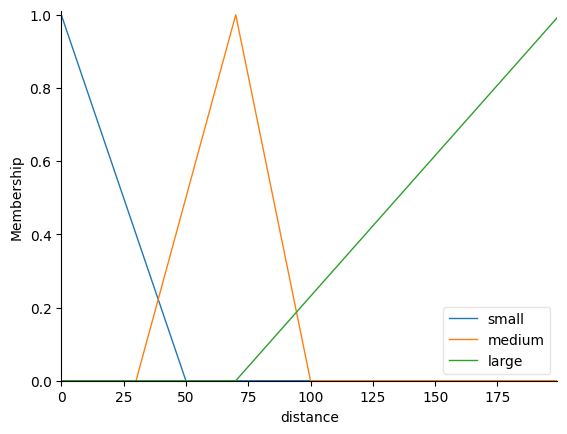

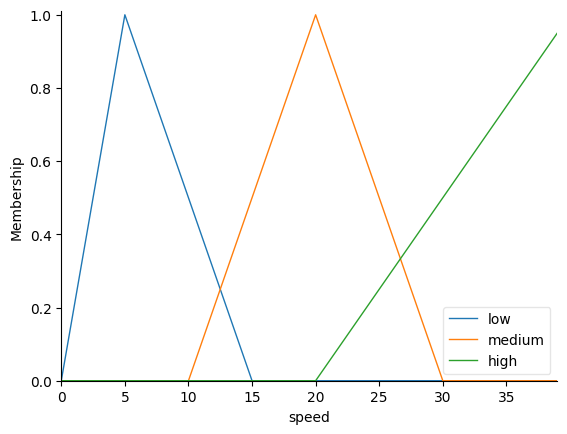

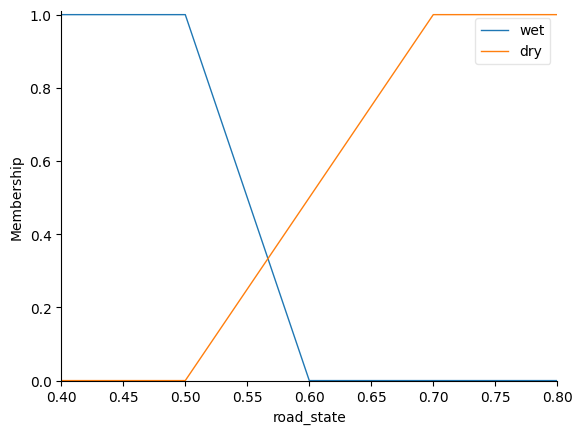

In [8]:
for variable in (distance, speed, road_state):
    variable.view()

### Define target variable

We define target variable as continious one, so the crisp value is the highest scoring membership.

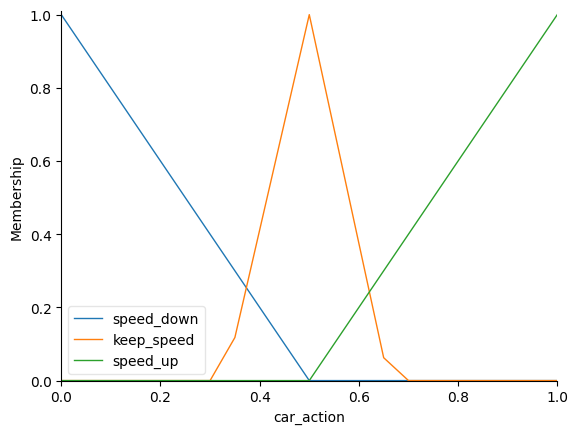

In [9]:
car_action = ctrl.Consequent(np.arange(0, 1 + 0.05, 0.05), 'car_action', 'som')

car_action['speed_down'] = fuzz.trimf(car_action.universe, [0, 0, 0.5])
car_action['keep_speed'] = fuzz.trimf(car_action.universe, [0.33, 0.5, 0.66])
car_action['speed_up'] = fuzz.trimf(car_action.universe, [0.5, 1, 1])

car_action.view()

### Defining rules

A set of rules defined like this:

distance[small] AND speed[high] => [car_action[speed_down]]  
distance[small] AND speed[medium] => [car_action[speed_down]]  
distance[small] AND speed[low] => [car_action[speed_down]]  
distance[medium] AND speed[high] => [car_action[speed_down]]  
distance[medium] AND speed[medium] => [car_action[keep_speed]]  
distance[medium] AND speed[low] => [car_action[speed_up]]  
distance[large] AND speed[high] => [car_action[keep_speed]]  
distance[large] AND speed[medium] => [car_action[speed_up]]  
distance[large] AND speed[low] => [car_action[speed_up]]  
road_state[wet] AND distance[small] => [car_action[speed_down]]  
road_state[wet] AND speed[high] => [car_action[speed_down]]  
(road_state[dry] AND distance[medium]) AND speed[medium] => [car_action[keep_speed]]  
(road_state[dry] AND distance[large]) AND speed[high] => [car_action[keep_speed]]  
road_state[dry] AND speed[low] => [car_action[keep_speed]]  
road_state[wet] AND speed[medium] => [car_action[keep_speed]]  

In [10]:
# Rules defined by access to computed value stored in a context

rules = [
    lambda ctx: np.fmin(np.fmin(ctx['distance']['small'], ctx['speed']['high']), car_action['speed_down'].mf),
    lambda ctx: np.fmin(np.fmin(ctx['distance']['small'], ctx['speed']['medium']), car_action['speed_down'].mf),
    lambda ctx: np.fmin(np.fmin(ctx['distance']['small'], ctx['speed']['low']), car_action['speed_down'].mf),
                                                                                                     
    lambda ctx: np.fmin(np.fmin(ctx['distance']['medium'], ctx['speed']['high']), car_action['speed_down'].mf),
    lambda ctx: np.fmin(np.fmin(ctx['distance']['medium'], ctx['speed']['medium']), car_action['keep_speed'].mf),
    lambda ctx: np.fmin(np.fmin(ctx['distance']['medium'], ctx['speed']['low']), car_action['speed_up'].mf) ,
                                                                                                     
    lambda ctx: np.fmin(np.fmin(ctx['distance']['large'], ctx['speed']['high']), car_action['keep_speed'].mf),
    lambda ctx: np.fmin(np.fmin(ctx['distance']['large'], ctx['speed']['medium']), car_action['speed_up'].mf),
    lambda ctx: np.fmin(np.fmin(ctx['distance']['large'], ctx['speed']['low']), car_action['speed_up'].mf),
                                                                                                     
    lambda ctx: np.fmin(np.fmin(ctx['road_state']['wet'], ctx['distance']['small']), car_action['speed_down'].mf),
    lambda ctx: np.fmin(np.fmin(ctx['road_state']['wet'], ctx['speed']['high']), car_action['speed_down'].mf),
                                                                                                    
    lambda ctx: np.fmin(np.fmin(ctx['road_state']['dry'], np.fmin(ctx['distance']['medium'], ctx['speed']['medium'])), car_action['keep_speed'].mf),
    lambda ctx: np.fmin(np.fmin(ctx['road_state']['dry'], np.fmin(ctx['distance']['large'], ctx['speed']['high'])), car_action['keep_speed'].mf),
    lambda ctx: np.fmin(np.fmin(ctx['road_state']['dry'], ctx['speed']['low']), car_action['keep_speed'].mf),
                                                                                                    
    lambda ctx: np.fmin(np.fmin(ctx['road_state']['wet'], ctx['speed']['medium']), car_action['keep_speed'].mf)                        
]

In [11]:
def redraw_figure(figure, target_ax):
    figure.canvas.draw()
    rgba_bytes      = figure.canvas.buffer_rgba().tobytes()
    width, height   = figure.canvas.get_width_height()

    pil_image = Image.frombytes(
        mode="RGBA",
        size=[width, height],
        data=rgba_bytes,
    )
    image_array = np.array(pil_image)

    plt.close()

    target_ax.axis('off')
    target_ax.imshow(image_array)

def plot_rule(activation, target_ax):
    fig, ax = ctrl.visualization.FuzzyVariableVisualizer(car_action).view()
    ax.fill_between(
        car_action.universe, 
        np.zeros_like(car_action.universe), 
        activation, 
        facecolor='b', 
        alpha=0.7
    )

    redraw_figure(fig, target_ax)

def plot_result(activation, centroid_x, centroid, target_ax):
    fig, ax = ctrl.visualization.FuzzyVariableVisualizer(car_action).view()
    ax.fill_between(
        car_action.universe, 
        np.zeros_like(car_action.universe), 
        activation, 
        facecolor='b', 
        alpha=0.7
    )

    ax.plot([centroid_x, centroid_x], [0, centroid], 'k', linewidth=1.5, alpha=0.9)
    redraw_figure(fig, target_ax)

### Mamdani inference

Here Mamdani fuzzy inference is implemented:
* Get the membership values of antecedents
* Use `max` and `min` as | and & to get the activation function
* Use `min` as implication between activation and consequent membership function
* Aggregate consequent activation with `max` 
* Find the centroid of the figure under the function curve - that is crisp output

In [12]:
def select_action(speed_in, distance_in, road_state_in, debug=False):
    
    def interpret(variable, raw_input):
        interpretations = {}
        for term in variable.terms:
            interpretations[term] = fuzz.interp_membership(variable.universe, variable[term].mf, raw_input)

        return interpretations

    speed_interpretations = interpret(speed, speed_in)
    distance_interpretations = interpret(distance, distance_in)
    road_state_interpretations = interpret(road_state, road_state_in)

    context = {
        'speed': speed_interpretations,
        'distance': distance_interpretations,
        'road_state': road_state_interpretations
    }

    if debug:
        fig = plt.figure(figsize=(15, 8))
        gs_main = gridspec.GridSpec(1, 2, figure=fig)
        gs_activations = gridspec.GridSpecFromSubplotSpec(4, 4,subplot_spec=gs_main[0])

    acc = None
    for idx, rule in enumerate(rules):
        activation = rule(context)
        
        if debug:
            ax = fig.add_subplot(gs_activations[idx // 4, idx % 4])
            plot_rule(activation, ax)
        
        if acc is None:
            acc = activation
            continue

        acc = np.fmax(acc, activation)
    
    try:
        activation_x = fuzz.defuzz(car_action.universe, acc, 'centroid')
    except:
        activation_x = 0.0

    if debug:
        activation = fuzz.interp_membership(car_action.universe, acc, activation_x)
        ax = fig.add_subplot(gs_main[1])
        plot_result(acc, activation_x, activation, ax)
        plt.show()

        print(context)

    interpretation = interpret(car_action, activation_x)
    selected_action = max(interpretation.items(), key = lambda kv: kv[1])[0]

    return activation_x, interpretation, selected_action

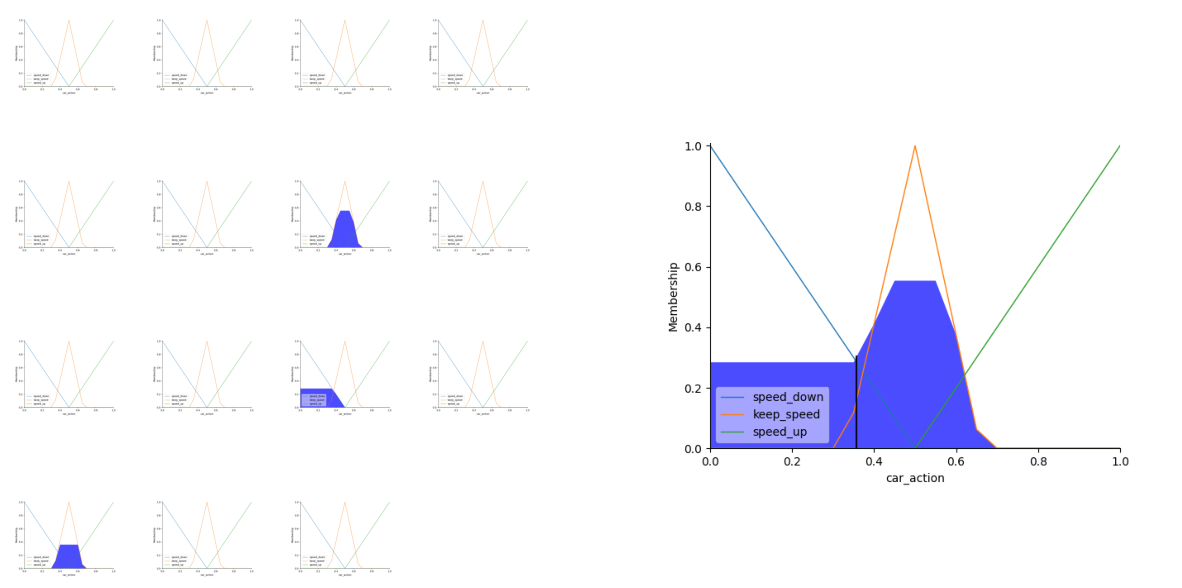

{'speed': {'low': 0.0, 'medium': 0.0, 'high': 0.6896999999999998}, 'distance': {'small': 0.0, 'medium': 0.0, 'large': 0.5538461538461539}, 'road_state': {'wet': 0.2842759227901771, 'dry': 0.35786203860491145}}
[142.          33.794        0.57157241] => speed_down


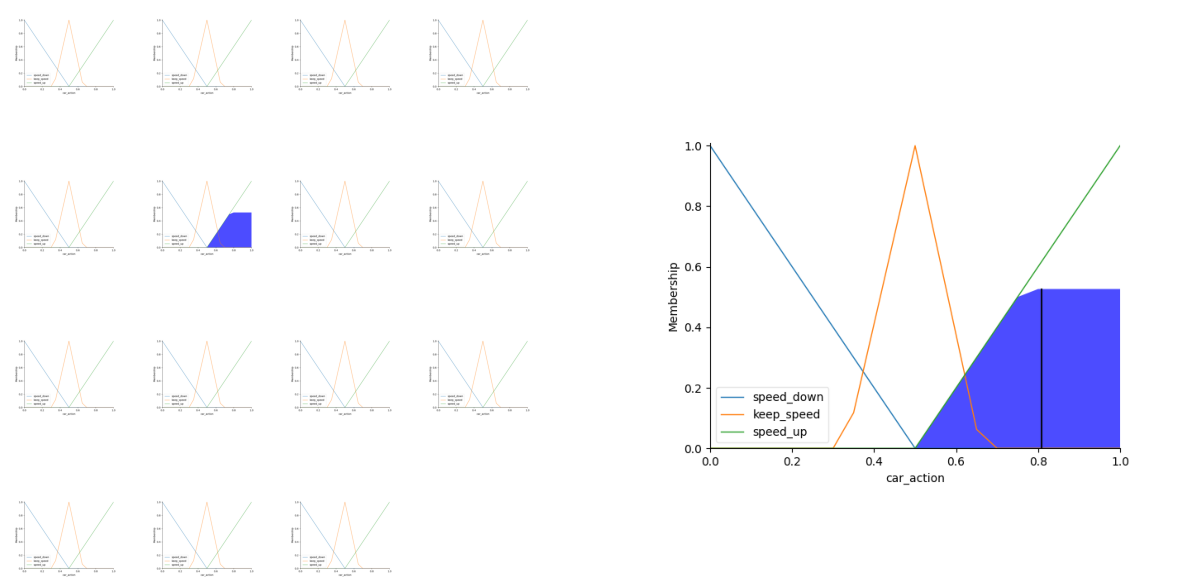

{'speed': {'low': 0.5264, 'medium': 0.0, 'high': 0.0}, 'distance': {'small': 0.0, 'medium': 1.0, 'large': 0.0}, 'road_state': {'wet': 1.0, 'dry': 0.0}}
[70.          2.632       0.44340267] => speed_up


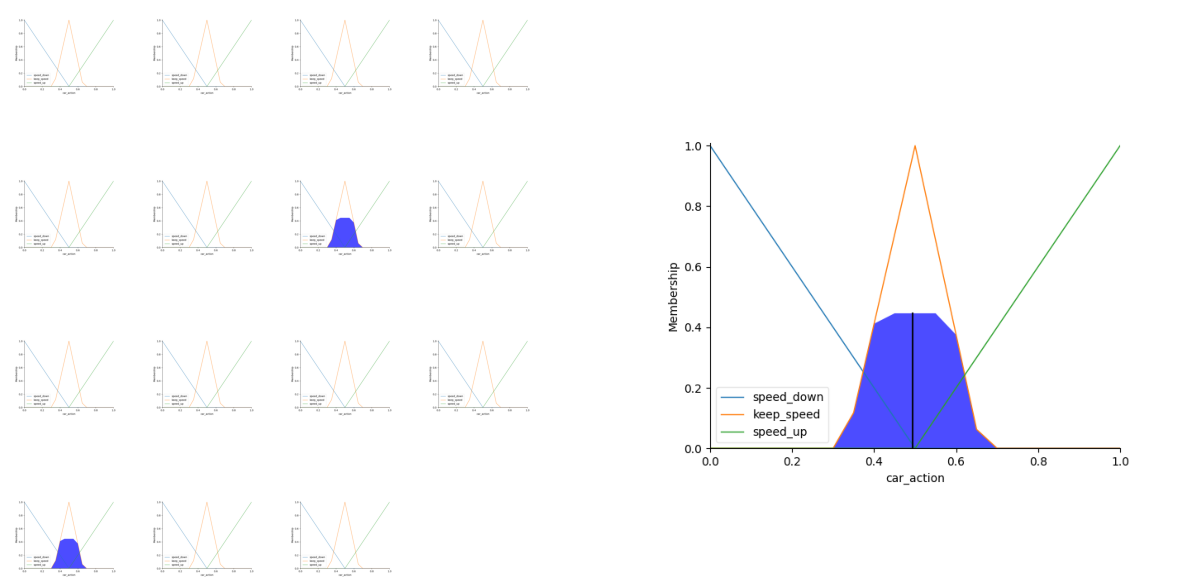

{'speed': {'low': 0.0, 'medium': 0.0, 'high': 0.5485}, 'distance': {'small': 0.0, 'medium': 0.0, 'large': 0.4461538461538462}, 'road_state': {'wet': 0.0, 'dry': 0.5471730491248695}}
[128.          30.97         0.60943461] => keep_speed


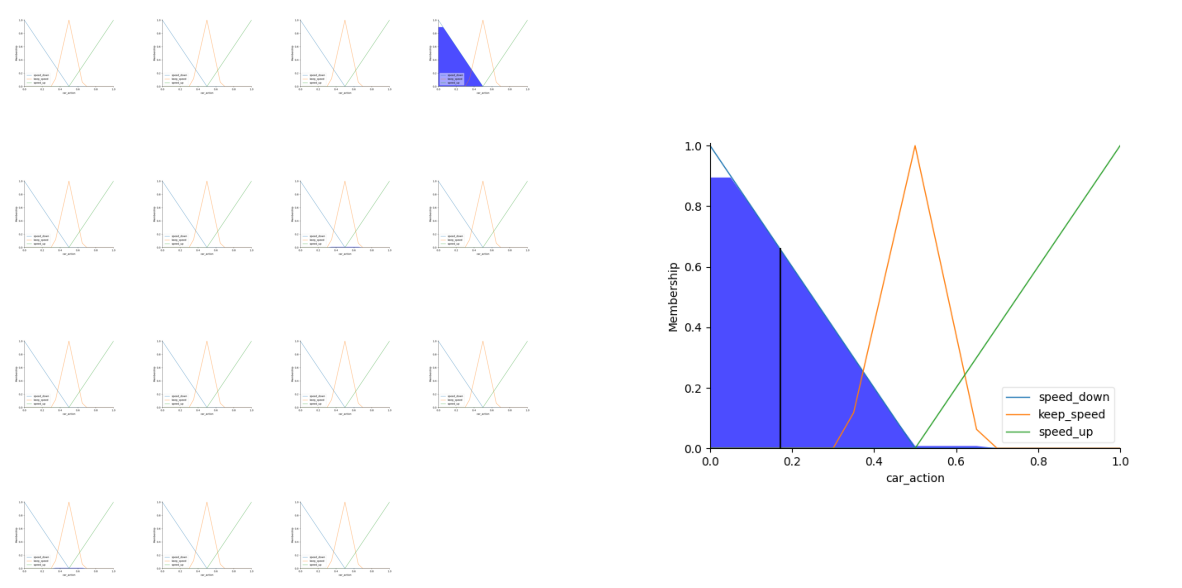

{'speed': {'low': 0.0, 'medium': 0.0, 'high': 0.8948499999999999}, 'distance': {'small': 0.0, 'medium': 0.9666666666666667, 'large': 0.007692307692307693}, 'road_state': {'wet': 0.0, 'dry': 1.0}}
[71.         37.897       0.77053273] => speed_down


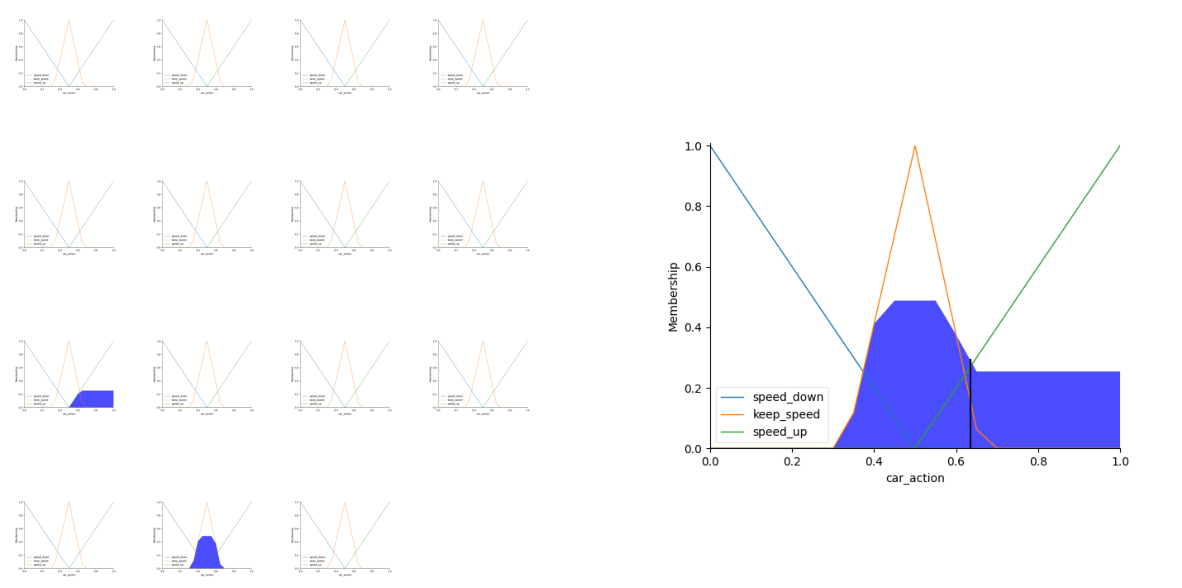

{'speed': {'low': 0.6776, 'medium': 0.0, 'high': 0.0}, 'distance': {'small': 0.0, 'medium': 0.0, 'large': 0.25384615384615383}, 'road_state': {'wet': 0.024010724784575554, 'dry': 0.4879946376077122}}
[103.           8.224        0.59759893] => speed_up


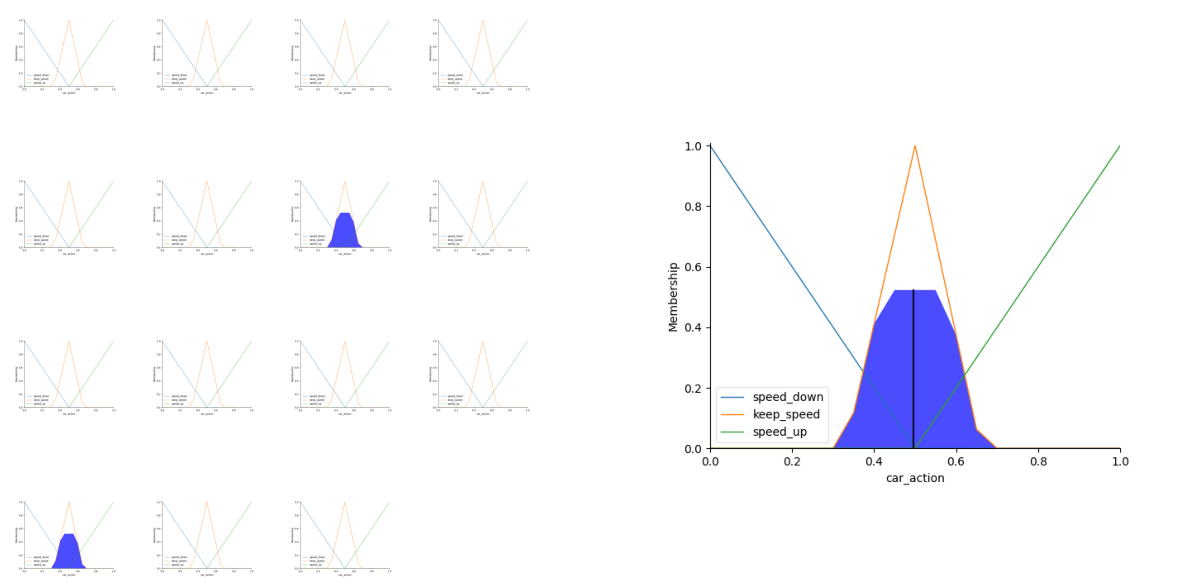

{'speed': {'low': 0.0, 'medium': 0.0, 'high': 0.8366499999999999}, 'distance': {'small': 0.0, 'medium': 0.0, 'large': 0.5230769230769231}, 'road_state': {'wet': 0.0, 'dry': 0.5324284864415608}}
[138.         36.733       0.6064857] => keep_speed


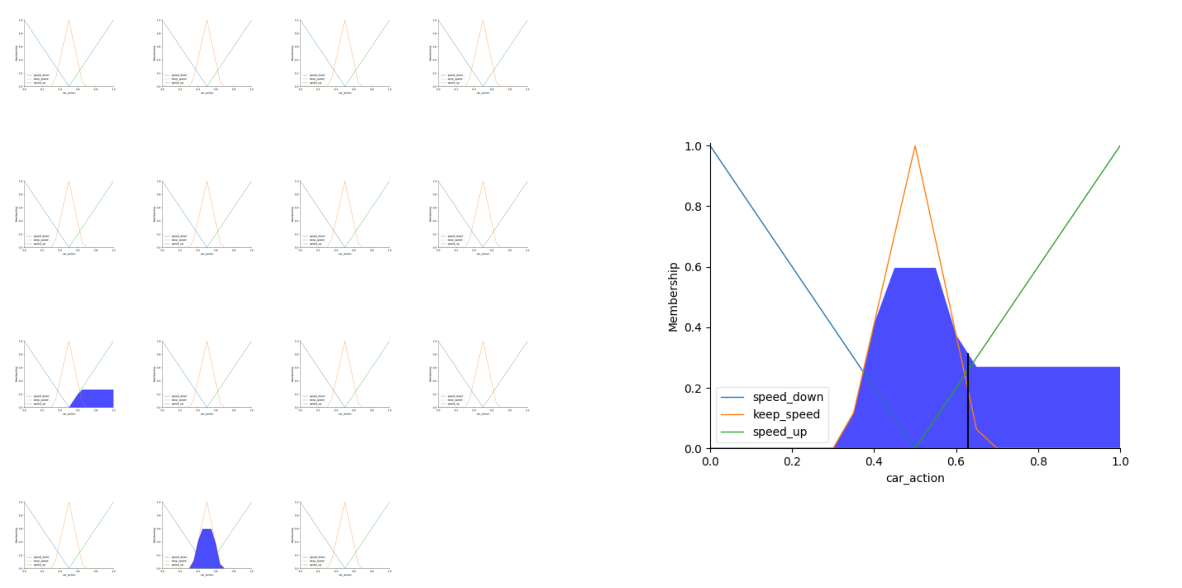

{'speed': {'low': 0.6192, 'medium': 0.0, 'high': 0.0}, 'distance': {'small': 0.0, 'medium': 0.0, 'large': 0.2692307692307692}, 'road_state': {'wet': 0.0, 'dry': 0.5964626971997445}}
[105.           3.096        0.61929254] => speed_up


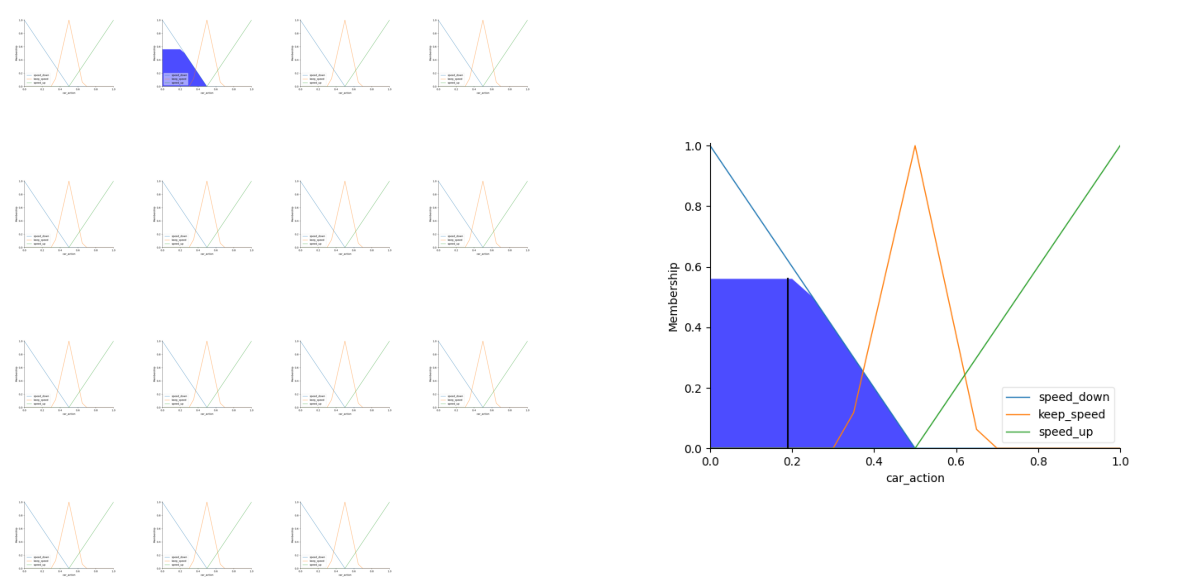

{'speed': {'low': 0.0, 'medium': 0.8065000000000002, 'high': 0.0}, 'distance': {'small': 0.56, 'medium': 0.0, 'large': 0.0}, 'road_state': {'wet': 0.0, 'dry': 0.5821036725780472}}
[22.         18.065       0.61642073] => speed_down


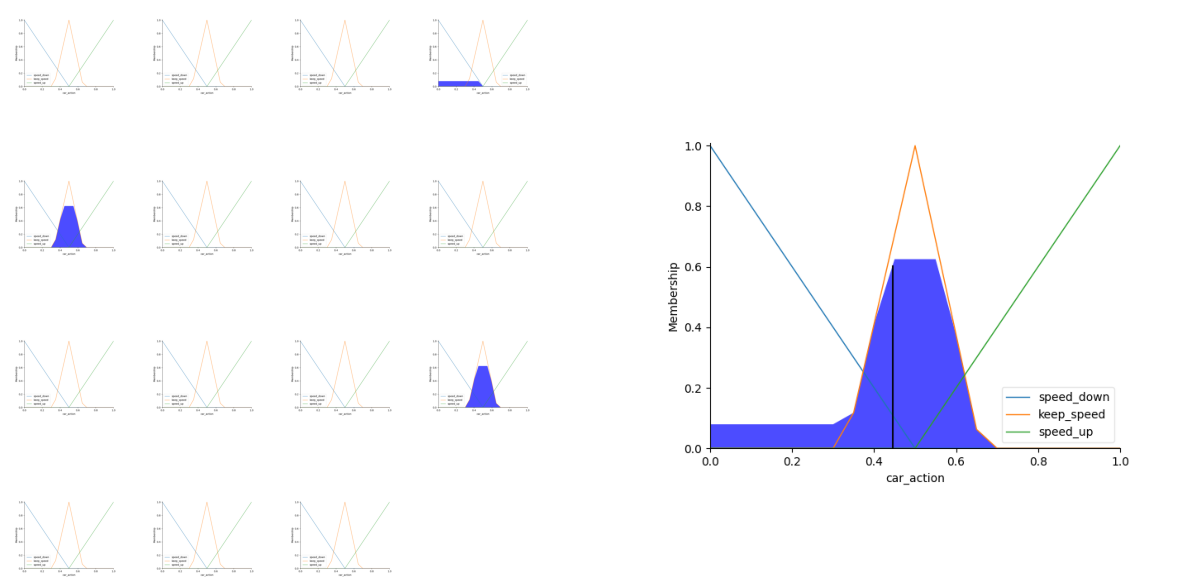

{'speed': {'low': 0.0, 'medium': 0.8411000000000002, 'high': 0.07944999999999994}, 'distance': {'small': 0.0, 'medium': 0.625, 'large': 0.0}, 'road_state': {'wet': 0.0, 'dry': 1.0}}
[55.         21.589       0.75871095] => keep_speed


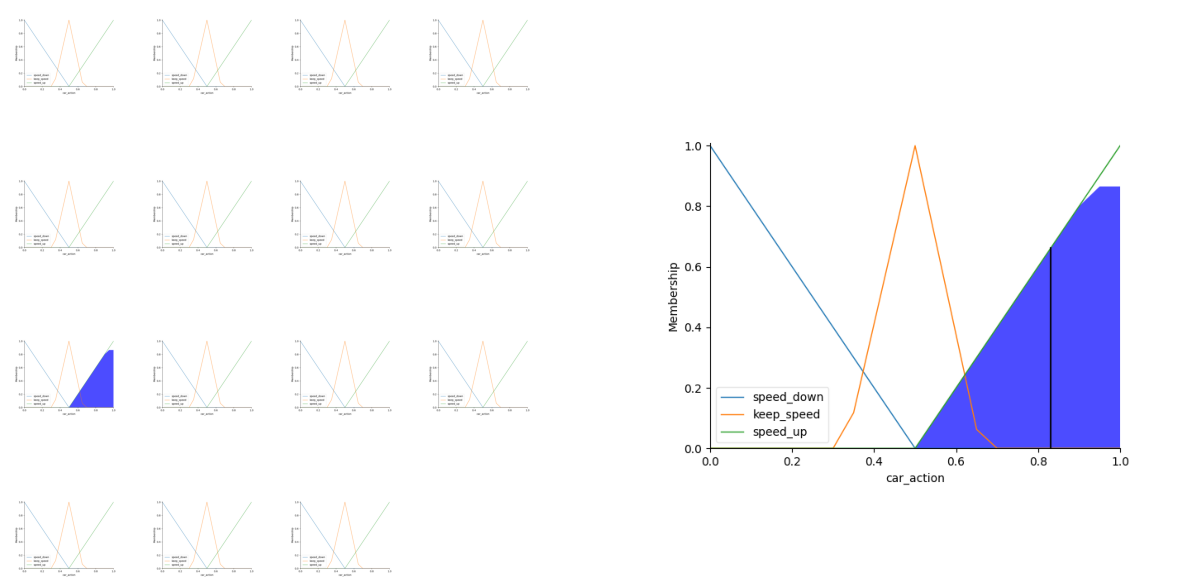

{'speed': {'low': 0.8652, 'medium': 0.0, 'high': 0.0}, 'distance': {'small': 0.0, 'medium': 0.0, 'large': 0.9692307692307692}, 'road_state': {'wet': 1.0, 'dry': 0.0}}
[196.           4.326        0.47806066] => speed_up


In [14]:
samples = df.sample(10, random_state=123)

for sample in samples.to_numpy():
    _, _, action = select_action(
        speed_in=sample[1], 
        distance_in=sample[0], 
        road_state_in=sample[2], 
        debug=True
    )
    print(f"{sample} => {action}")

# Continious control

Our dataset can be interpreted as an input to a problem of stopping the car on some target spot (here an obstacle). Following code can run a simulation of car movement controlled by our fuzzy system.

In [40]:
def simulate_movement(speed_in, distance_in, road_state_in, polling_rate, verbose=False):
    current_speed = speed_in
    current_distance = distance_in
    friction = road_state_in

    g = 9.81
    acceleration = 5

    history = []
    delta = 1 / polling_rate
    timestamp = 0.0

    while current_distance > 1e-6 and current_speed > 1e-6:
        _, _, action = select_action(speed_in=current_speed, distance_in=current_distance, road_state_in=friction)

        history_entry = (timestamp, current_speed, current_distance, action)
        history.append(history_entry)

        if verbose:
            print(f"{timestamp}: {(current_speed, current_distance)} => {action}")

        if action == "speed up":
            current_speed = current_speed + acceleration * delta
        elif action == "speed_down":
            current_speed = current_speed - g * friction * delta
        
        current_distance = current_distance - current_speed * delta
        timestamp = timestamp + delta

    return history, (current_distance, current_speed)

In [41]:
def plot_history(history):
    fig, ax = plt.subplots(1, 2)

    xs = list(map(lambda e: e[0], history))
    speed = list(map(lambda e: e[1], history))
    distance = list(map(lambda e: e[2], history))

    ax[0].plot(xs, speed)
    ax[0].set_title("Speed over time")

    ax[1].plot(xs, distance)
    ax[1].set_title("Distance over time")

    plt.show()

(-0.047794000000466345, 2.9569300000000873)


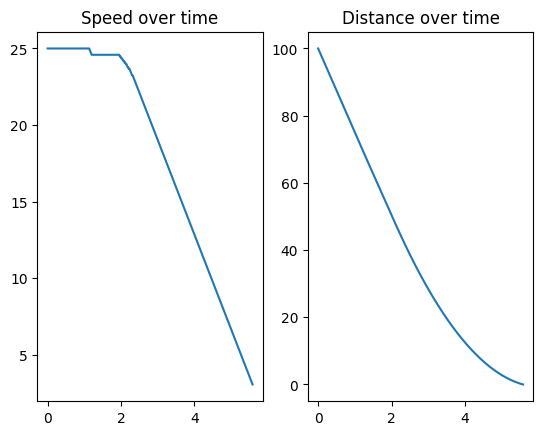

In [43]:
history, final_state = simulate_movement(
    speed_in=25,
    distance_in=100,
    road_state_in=0.63,
    polling_rate=60,
    verbose=False
)

print(final_state)
plot_history(history)